In [1]:
!pip install shapely
#!pip install pyproj
!pip install folium
#!pip install utm
!pip install beautifulsoup4
!pip install geocoder

     |████████████████████████████████| 98 kB 782 kB/s eta 0:00:01


In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests # library to handle requests
import shapely.geometry
import math
import folium
from bs4 import BeautifulSoup
import geocoder
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap

## center of pune
pune_center = [18.5204303, 73.8567437]
## Foursquare authentication keys
CLIENT_ID = ''
CLIENT_SECRET = ''
## Radius in KMs
RADIUS=1000
VERSION=20210902
LIMIT = 100

In [3]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Pune").text

soup = BeautifulSoup(data, 'html.parser')

neighbors = []
for row in soup.find_all("div",  {"class": "mw-category"})[0].findAll("li"):
    neighbors.append(row.text)
    
#Create a new DataFrame from the list
df_neighbors = pd.DataFrame({"neighbor": neighbors})
df_neighbors = df_neighbors.drop(labels=[26,32,39, 40, 46], axis=0)
df_neighbors.reset_index(drop=True)


,neighbor
0,Appa Balwant Chowk
1,"Aundh, Pune"
2,Balewadi
3,Baner
4,Bavdhan
5,"Bhavani Peth, Pune"
6,Blue Ridge Town Pune
7,"Budhwar Peth, Pune"
8,"Chakan, Pune"
9,Dapodi


In [4]:
## Function to fetch the geo coordinates for the locations
def getNeighborCoords(neighbor):
    # initialize your variable to None
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        x=neighbor.replace(', Pune','').replace('Pune','').strip()
        geo = geocoder.arcgis('{}, Pune, India'.format(x))
        lat_lng_coords = geo.latlng
    
    return lat_lng_coords

# Call the function to get the coordinates, store in a new list using list comprehension
coords = [ getNeighborCoords(neighbor) for neighbor in df_neighbors["neighbor"].tolist()]

## Map the latitude and longitude retuned from the function 
df_neighbors['latitude'], df_neighbors['longitude'] = zip(*coords)

In [ ]:
df_neighbors.head()

In [5]:
## Add extra prominent places to main DataFrame as these were not avaialble on the Wikipedia
places = [('Wanwadi',18.4922, 73.9000),
            ('Katraj',18.4529, 73.8652),
            ('Shivajinagar',18.5314, 73.8446),
            ('Kondhwa',18.4695, 73.8890),
            ('Ghorpadi',18.5236, 73.9063),
            ('Pimple Saudagar',18.5987, 73.7978),
            ('Nigdi',18.6492, 73.7707),
            ('Morewadi',18.6333, 73.8051),
            ('Wagholi',18.5808, 73.9787),
            ('Mundhwa',18.5330, 73.9330),   
            ('Pune Railway Station',18.5284, 73.8739),
            ('Lullanagar',18.4853, 73.8836),
            ('Karve Nagar',18.4853, 73.8836),
            ('Paud Road',18.5085, 73.7934),
            ('Khadki',18.5626, 73.8524),
            ('NIBM',18.4765, 73.9006),
            ('Akurdi',18.6505, 73.7786),
            ('Bund Garden',18.5421, 73.8816),
            ('Pune University', 18.5558, 73.8224),
            ('Punawale', 18.6309, 73.7378),
            ('Pimpri Chinchwad',18.6298, 73.7997),
            ('Nigdi', 18.6492, 73.7707)

         ]

dt = pd.DataFrame(places,columns=('neighbor', 'latitude', 'longitude'))
df_neighbors = df_neighbors.append(dt, ignore_index=True)

df_neighbors.sort_values(by=['neighbor'])
df_neighbors.reset_index(drop=True, inplace=True)

In [6]:

## center of pune
pune_center = [18.5204303, 73.8567437]

## plot the neighbors on the map using Folium library

map_pune = folium.Map(location=pune_center, zoom_start=11)
#folium.Marker(pune_center, popup='Pune').add_to(map_pune)
for neighbor, lat, lon in  zip(df_neighbors['neighbor'],
                                   df_neighbors['latitude'],
                               df_neighbors['longitude']):
    label = '{}'.format(neighbor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, color='black', fill_color='blue',
                        fill_opacity=0.25, popup=label, fill=True).add_to(map_pune)
    
map_pune

In [7]:
## Get the Foursquare venue category
def get_category_type(row):
    try:
        categories_list = row['categories']
        
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Get the Nearby Venues using the FourSquare API for defined radius
def getNearbyVenues(names, latitudes, longitudes):
    
    foursquare_venues = pd.DataFrame(columns = ['neighbor','latitude','longitude','name', 'categories', 'lat', 'lng'])

    offset=0
    total_venues_fetched=0
    
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        
        
        venues_list=[]    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&categoryId=4bf58dd8d48988d116941735&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            RADIUS, 
            LIMIT,offset)
        
#         print(name, latitude, longitude)
#         print (url)
        try:
            result = requests.get(url).json()
        except Exception:
            print("No food venues: {} ".format(name))
            continue;
            
        if len(result) == 0:
            print("No food venues: {} ".format(name))    

        venues_count = result['response']['totalResults'] 

        total_venues_fetched += venues_count
        
        
        if venues_count > 0:
            venues = result['response']['groups'][0]['items']
            venues = pd.json_normalize(venues)
            # Filter the columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            venues = venues.loc[:, filtered_columns]

            # Filter the category for each row
            venues['venue.categories'] = venues.apply(get_category_type, axis = 1)
            #print(venues)
            
            venues.insert(0, 'neighbor', name)
            venues.insert(1, 'latitude', latitude)
            venues.insert(2, 'longitude', longitude)
            
            venues.columns = [col.split(".")[-1] for col in venues.columns]
            foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
            
        else:
            ## if there are no venues, just add entry of neighbor with nan for other columns             
            foursquare_venues.loc[len(foursquare_venues.index)] = [name,latitude,longitude,np.nan,np.nan,np.nan,np.nan] 

    print ("Total Hotels Fetched: {}".format(total_venues_fetched))
    
    return (foursquare_venues)

In [8]:
df_Venues = getNearbyVenues(df_neighbors['neighbor'],df_neighbors['latitude'],df_neighbors['longitude'])

Total Hotels Fetched: 162


In [9]:
df_org_venues = df_Venues.copy()

In [10]:
df_Venues.dropna(how='any', inplace=True)
df_Venues.reset_index(drop=True, inplace=True)
df_Venues.head()

,neighbor,latitude,longitude,name,categories,lat,lng
0,Appa Balwant Chowk,18.516484,73.85387,Apache Fluid Lounge,Bar,18.517046,73.847277
1,Appa Balwant Chowk,18.516484,73.85387,Hotel Deccan Royal,Hotel,18.519167,73.845223
2,"Aundh, Pune",18.563450,73.81227,Chandrama Restaurant & Bar,Bar,18.560673,73.809402
3,"Aundh, Pune",18.563450,73.81227,Has Juice Bar,Juice Bar,18.560431,73.805131
4,Balewadi,18.576020,73.77983,Apache - High Street,Bar,18.569373,73.774731


In [ ]:
df_Venues.shape

In [11]:
df_Venues.loc[df_Venues['name']=='Hidden Place - The Crazy Frog']

,neighbor,latitude,longitude,name,categories,lat,lng
138,Pune Railway Station,18.5284,73.8739,Hidden Place - The Crazy Frog,Pub,18.536546,73.875394
150,Bund Garden,18.5421,73.8816,Hidden Place - The Crazy Frog,Pub,18.536546,73.875394


In [12]:
df_Venues.loc[df_Venues.duplicated(['name','lat','lng']), :].sort_values(by='name')

,neighbor,latitude,longitude,name,categories,lat,lng
71,"Narayan Peth, Pune",18.51530,73.84939,Amrapali Restuarant and Bar,Bar,18.519487,73.841318
17,"Budhwar Peth, Pune",18.51689,73.85617,Apache Fluid Lounge,Bar,18.517046,73.847277
20,Deccan Gymkhana,18.51585,73.84061,Apache Fluid Lounge,Bar,18.517046,73.847277
94,"Shaniwar Peth, Pune",18.51857,73.85360,Apache Fluid Lounge,Bar,18.517046,73.847277
90,"Sadashiv Peth, Pune",18.51112,73.85150,Apache Fluid Lounge,Bar,18.517046,73.847277
70,"Narayan Peth, Pune",18.51530,73.84939,Apache Fluid Lounge,Bar,18.517046,73.847277
92,"Sadashiv Peth, Pune",18.51112,73.85150,Apsara Restaurant,Bar,18.503161,73.854108
106,Swargate,18.49903,73.85843,Apsara Restaurant,Bar,18.503161,73.854108
99,"Shukrawar Peth, Pune",18.50395,73.85810,Apsara Restaurant,Bar,18.503161,73.854108
105,Swargate,18.49903,73.85843,Ashray Hotel,Hotel Bar,18.496712,73.857559


In [13]:
df_Venues.drop_duplicates(subset=['name','categories','lat','lng'], keep='first', inplace=True)

In [ ]:
df_Venues.shape

In [ ]:
df_Venues['categories'].unique()

In [14]:
## filter out only Bars from the fetched venues

df_hotels = df_Venues[df_Venues['categories'].isin(['Bar', 'Hotel Bar','Pub', 'Cocktail Bar', 
                                                    'Lounge','Sports Bar', 'Gastropub','Brewery','Distillery']) ]
df_hotels.reset_index(drop=True, inplace=True)

## rearrange and rename the columns
df_hotels.columns=['neighbor','latitude','longitude','venue','category','venue_lat','venue_lon']
df_hotels.head()


,neighbor,latitude,longitude,venue,category,venue_lat,venue_lon
0,Appa Balwant Chowk,18.516484,73.85387,Apache Fluid Lounge,Bar,18.517046,73.847277
1,"Aundh, Pune",18.563450,73.81227,Chandrama Restaurant & Bar,Bar,18.560673,73.809402
2,Balewadi,18.576020,73.77983,Apache - High Street,Bar,18.569373,73.774731
3,Balewadi,18.576020,73.77983,Tales And Spirits,Cocktail Bar,18.571497,73.775040
4,Baner,18.548200,73.77316,Rangla Punjab,Bar,18.542539,73.776368


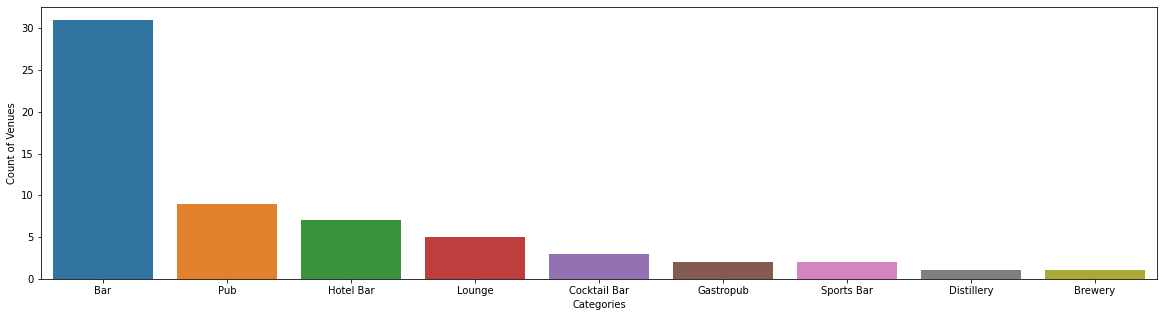

In [15]:
### plot the bar graph to visualize the distribution 
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_hotels['category'].value_counts().index, 
            y=df_hotels['category'].value_counts())
plt.xlabel("Categories")
plt.ylabel("Count of Venues")

plt.show()


In [16]:
## one-hot encode the category
df_hotels_OHE = pd.get_dummies(df_hotels['category'], prefix='', prefix_sep='')
df_hotels_OHE['neighbor'] = df_hotels['neighbor']

fixed_columns = [df_hotels_OHE.columns[-1]] + list(df_hotels_OHE.columns[:-1])
df_hotels_OHE = df_hotels_OHE[fixed_columns]

df_hotels_OHE.head(5)

,neighbor,Bar,Brewery,Cocktail Bar,Distillery,Gastropub,Hotel Bar,Lounge,Pub,Sports Bar
0,Appa Balwant Chowk,1,0,0,0,0,0,0,0,0
1,"Aundh, Pune",1,0,0,0,0,0,0,0,0
2,Balewadi,1,0,0,0,0,0,0,0,0
3,Balewadi,0,0,1,0,0,0,0,0,0
4,Baner,1,0,0,0,0,0,0,0,0


In [ ]:
## for the sake of simplicity, let's mark all the category to "Bar"
#df_hotels['category'] = 'Bar'

In [17]:
## group the neighbors
df_hotels_grouped = df_hotels_OHE.groupby('neighbor').mean().reset_index()
df_hotels_grouped.head()

,neighbor,Bar,Brewery,Cocktail Bar,Distillery,Gastropub,Hotel Bar,Lounge,Pub,Sports Bar
0,Akurdi,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Appa Balwant Chowk,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Aundh, Pune",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Balewadi,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
4,Baner,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_hotels_grouped

### K-means Clustering

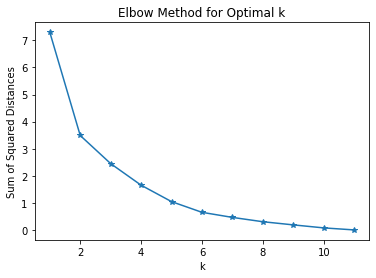

In [18]:
# Elbow method to find optimal K

clusters = []
inertia_vals = []
x = df_hotels_grouped.drop(['neighbor'], 1)

kmax = 12

# Since creating one cluster is similar to observing the data as a whole, multiple values of K are utilized to come up with the optimum cluster value
#Note: Cluster number and intra cluster distance is appended for plotting the elbow curve
for k in range(1, kmax, 1):
    
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=7)
    model.fit(x)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)
    
# plot the inertia vs K values
plt.plot(range(1,kmax,1),inertia_vals,marker='*')
plt.title("Elbow Method for Optimal k")
plt.xlabel("k")
plt.ylabel("Sum of Squared Distances")
plt.show()

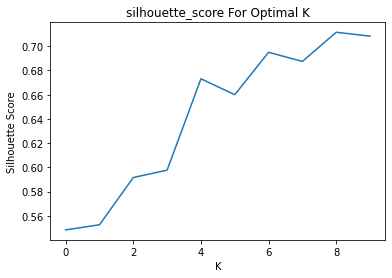

In [19]:
# Silhouette score method to find optimal K

from sklearn.metrics import silhouette_score

sil=[]
for k in range(2,kmax):
    kmeans = KMeans(n_clusters = k, random_state=5).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    
plt.plot(sil)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('silhouette_score For Optimal K')
plt.show()

In [20]:
# set number of clusters
kclusters = 8

x = df_hotels_grouped.drop(['neighbor'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(x)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 0, 2, 5, 1, 2, 5, 2], dtype=int32)

In [21]:
df_hotels_merged = df_hotels_grouped.copy()

# Add the clustering labels
df_hotels_merged["cluster"] = kmeans.labels_
df_clustered = pd.merge(df_hotels, df_hotels_merged[['neighbor','cluster']] ,on=["neighbor"])

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import itertools

occurences = folium.map.FeatureGroup()
map_clusters = folium.Map(location=pune_center, zoom_start=11)

# Setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(df_clustered['latitude'], df_clustered['longitude'], 
                                  df_clustered['neighbor'], df_clustered['cluster']):
    
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker([lat,lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1],
                        fill_opacity=1,
                        icon = folium.Icon(icon='beer', prefix='fa')).add_to(map_clusters)

map_clusters


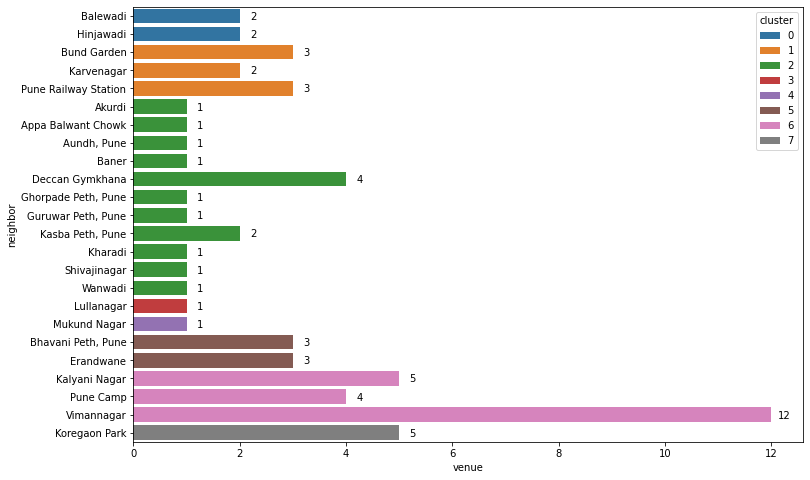

In [67]:
dfplot =  df_clustered.groupby(['cluster','neighbor']).agg(venue=("neighbor", 'count')).reset_index()
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='venue', y='neighbor', hue='cluster', ci = None, dodge=False, data=dfplot)

for p in ax.patches:
    width = p.get_width()
    plt.text(0.25+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')

In [69]:
pd.options.display.max_colwidth=200
dx = df_clustered[['cluster','neighbor']].drop_duplicates().sort_values(by='cluster')
dx = dx.groupby(['cluster'])[['neighbor']].transform(lambda x : ' / '.join(x)).drop_duplicates()
dx = dx.merge(df_clustered[['cluster']], left_index=True, right_index=True)
dx = dx.reset_index(drop=True)
dx

,neighbor,cluster
0,Balewadi / Hinjawadi,0
1,Karvenagar / Pune Railway Station / Bund Garden,1
2,"Deccan Gymkhana / Aundh, Pune / Shivajinagar / Wanwadi / Kharadi / Kasba Peth, Pune / Appa Balwant Chowk / Baner / Guruwar Peth, Pune / Ghorpade Peth, Pune / Akurdi",2
3,Lullanagar,3
4,Mukund Nagar,4
5,"Bhavani Peth, Pune / Erandwane",5
6,Kalyani Nagar / Pune Camp / Vimannagar,6
7,Koregaon Park,7


In [73]:
pune_latlons = df_clustered[['venue_lat','venue_lon']]

pune_map = folium.Map(location=pune_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(pune_map) #cartodbpositron cartodbdark_matter
HeatMap(pune_latlons, blur=20).add_to(pune_map)

#folium.Marker(pune_center).add_to(pune_map)
folium.Circle(pune_center, radius=2000, fill=False, color='white').add_to(pune_map)
folium.Circle(pune_center, radius=4000, fill=False, color='white').add_to(pune_map)
#folium.Circle(pune_center, radius=6000, fill=False, color='white').add_to(pune_map)
pune_map

In [74]:
df_neighbor_HM = df_clustered.groupby(['neighbor','latitude','longitude'])['category'].count().reset_index()

pune_latlons = df_neighbor_HM[['latitude','longitude','category']]

pune_map = folium.Map(location=pune_center, zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(pune_map) #cartodbpositron cartodbdark_matter
HeatMap(pune_latlons, blur=10).add_to(pune_map)

folium.Marker(pune_center).add_to(pune_map)
pune_map